<a href="https://colab.research.google.com/github/assayonare/free-data-exploration/blob/main/free-data-exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyarrow
!pip install fastparquet


In [2]:
import pandas as pd
import numpy as np

transactions = pd.read_parquet('/content/drive/MyDrive/data/transaction_fraud_data.parquet')
currency_rates = pd.read_parquet('/content/drive/MyDrive/data/historical_currency_exchange.parquet')




/tmp/ipython-input-2390833797.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_trans = transactions.groupby('is_fraud', group_keys=False).apply(


# Создание случайной стратифицированной выборки
Поскольку обьем данных не позволяет провести полноценный анализ с имеющимися мощностями, сократим выборку. Возьмем стратифицированную случайную выборку, то есть обеспечим сохранение доли мошеннических и нормальных транзакций

In [ ]:
sample_size = 1_000_000
sample_trans = transactions.groupby('is_fraud', group_keys=False).apply(
    lambda x: x.sample(int(sample_size * len(x) / len(transactions)), random_state=42)
).reset_index(drop=True)

del transactions

# Обзор полученных данных

In [4]:
print("\n=== HEAD ===")
print(sample_trans.head())

print("\n=== INFO ===")
print(sample_trans.info())


=== HEAD ===
  transaction_id customer_id       card_number                  timestamp  \
0    TX_71d5c80c  CUST_69635  6233576571847925 2024-10-03 08:30:04.036615   
1    TX_a59b74b5  CUST_82957  4554645177283128 2024-10-19 19:52:52.677840   
2    TX_94b21a6a  CUST_61556  4154964474225292 2024-10-10 18:48:41.094259   
3    TX_6bce6734  CUST_60601  4042933388448452 2024-10-20 00:18:09.182855   
4    TX_00b74a76  CUST_62476   376984062398426 2024-10-26 14:46:42.593281   

  vendor_category vendor_type          vendor    amount currency    country  \
0         Grocery      online     FreshDirect    850.11      AUD  Australia   
1      Healthcare    pharmacy      DuaneReade  22145.47      RUB     Russia   
2       Education    supplies  Barnes & Noble   2318.84      BRL     Brazil   
3             Gas       major          Texaco  25471.59      MXN     Mexico   
4          Retail      online            eBay    105.52      EUR    Germany   

   ... is_card_present       device channel     

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
print("\n=== Missing values (NaN count) ===")
na_counts = sample_trans.isna().sum()
print(na_counts)



=== Missing values (NaN count) ===
transaction_id             0
customer_id                0
card_number                0
timestamp                  0
vendor_category            0
vendor_type                0
vendor                     0
amount                     0
currency                   0
country                    0
city                       0
city_size                  0
card_type                  0
is_card_present            0
device                     0
channel                    0
device_fingerprint         0
ip_address                 0
is_outside_home_country    0
is_high_risk_vendor        0
is_weekend                 0
last_hour_activity         0
is_fraud                   0
dtype: int64


Отметим, что в данных отсутствуют пропуски, но стоит провести дополнительную проверку на пустые строки и спец. значения:

In [12]:
string_cols = sample_trans.select_dtypes(include=['object']).columns
for col in string_cols:
    empty_count = (sample_trans[col].astype(str).str.strip() == "").sum()
    special_na_count = sample_trans[col].astype(str).str.lower().isin(["na", "n/a", "null", "none", "unknown"]).sum()
    if empty_count > 0 or special_na_count > 0:
        print(f"{col}: empty={empty_count}, special_na={special_na_count}")

Проверка дубликатов по transaction_id:

In [13]:
dup_count = sample_trans['transaction_id'].duplicated().sum()
print(f"\nDuplicate transaction_id count: {dup_count}")



Duplicate transaction_id count: 123


Распределение целевой переменной:


=== Target distribution (is_fraud) ===
is_fraud
False    800271
True     199728
Name: count, dtype: int64
is_fraud
False    0.800272
True     0.199728
Name: proportion, dtype: float64


/tmp/ipython-input-2578970248.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_fraud', data=sample_trans, palette='Set2')


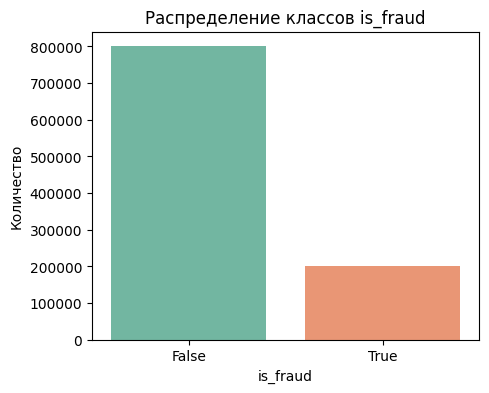

In [14]:
fraud_dist = sample_trans['is_fraud'].value_counts()
fraud_dist_norm = sample_trans['is_fraud'].value_counts(normalize=True)
print("\n=== Target distribution (is_fraud) ===")
print(fraud_dist)
print(fraud_dist_norm)

plt.figure(figsize=(5,4))
sns.countplot(x='is_fraud', data=sample_trans, palette='Set2')
plt.title("Распределение классов is_fraud")
plt.ylabel("Количество")
plt.show()

Количество легитимных транзакций составило 800271, что составляет ~80% от  общего числа транзакций, мошеннеческих - 199 728, около 20%. Датасет сбалансирован достаточно умеренно: дисбаланс есть, но не критичный.

Базовая статистика по сумме транзакций:


=== Amount stats ===
count    9.999990e+05
mean     4.817533e+04
std      1.803541e+05
min      1.000000e-02
25%      3.637700e+02
50%      1.180210e+03
75%      2.241817e+04
max      6.253153e+06
Name: amount, dtype: float64


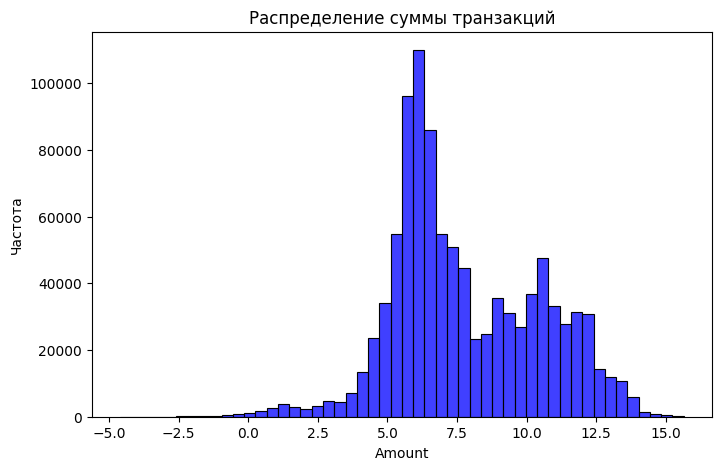

/tmp/ipython-input-2835158008.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y='amount', data=sample_trans, palette='Set2')


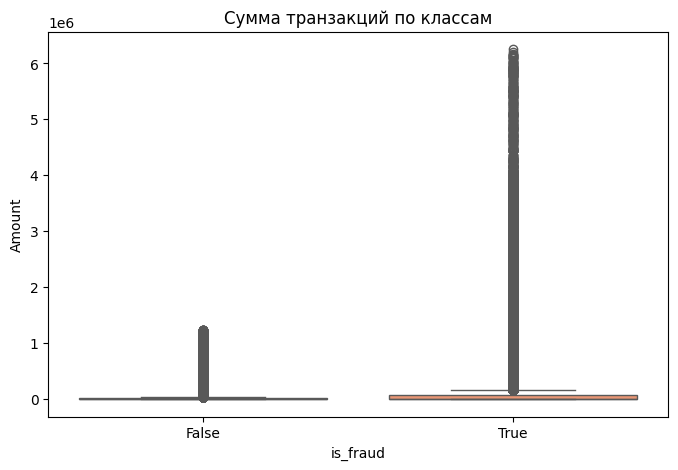

In [26]:
print("\n=== Amount stats ===")
print(sample_trans['amount'].describe())

plt.figure(figsize=(8,5))
sns.histplot(np.log(sample_trans['amount']), bins=50, color='blue', edgecolor='black')
plt.title("Распределение суммы транзакций")
plt.xlabel("Amount")
plt.ylabel("Частота")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='is_fraud', y='amount', data=sample_trans, palette='Set2')
plt.title("Сумма транзакций по классам")
plt.ylabel("Amount")
plt.show()


Распределение суммы транзакций сильно скошено вправо — много мелких платежей, но присутствуют редкие крупные суммы.

Обзор last_hour_activity:

In [17]:
lha_df = pd.json_normalize(sample_trans['last_hour_activity'])
print("\n=== Last Hour Activity stats ===")
print(lha_df.describe())


=== Last Hour Activity stats ===
       num_transactions  total_amount  unique_merchants  unique_countries  \
count     999999.000000  9.999990e+05     999999.000000     999999.000000   
mean         409.211128  1.991285e+07         80.035527         10.663850   
std          390.988654  3.561463e+07         30.462354          2.617714   
min            0.000000  5.081560e-02          0.000000          0.000000   
25%          105.000000  3.375473e+06         64.000000         11.000000   
50%          293.000000  1.019282e+07         95.000000         12.000000   
75%          607.000000  2.274960e+07        104.000000         12.000000   
max         3816.000000  1.056380e+09        105.000000         12.000000   

       max_single_amount  
count       9.999990e+05  
mean        1.729434e+06  
std         1.400857e+06  
min         5.081560e-02  
25%         8.026743e+05  
50%         1.238219e+06  
75%         2.302021e+06  
max         6.253153e+06  


Показатели активности содержат экстремальные значения, что указывает на сильные различия между типами клиентов num_transactions (кол-во транзакций): в среднем 409 за час, макс. 3816 — виден диапазон от нуля до тысяч транзакций (возможно, для бизнес-аккаунтов).

total_amount (общая сумма): среднее ≈ 19.91 млн, но есть значения > 1 млрд.

unique_merchants: от 0 до 105, медиана 95 — большинство аккаунтов взаимодействуют с большим числом продавцов.

unique_countries: медиана 12, максимум 12, фиксированный список стран.

max_single_amount: медиана ≈ 1.23 млн, максимум 6.25 млн — опять же, сильный сдвиг за счёт крупных операций.

Распределение по категориальным признакам:


=== Top categories for vendor_category ===
vendor_category
Entertainment    125654
Gas              125424
Education        125072
Healthcare       124947
Restaurant       124946
Retail           124934
Grocery          124567
Travel           124455
Name: count, dtype: int64
Unique values: 8


/tmp/ipython-input-2931784778.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')


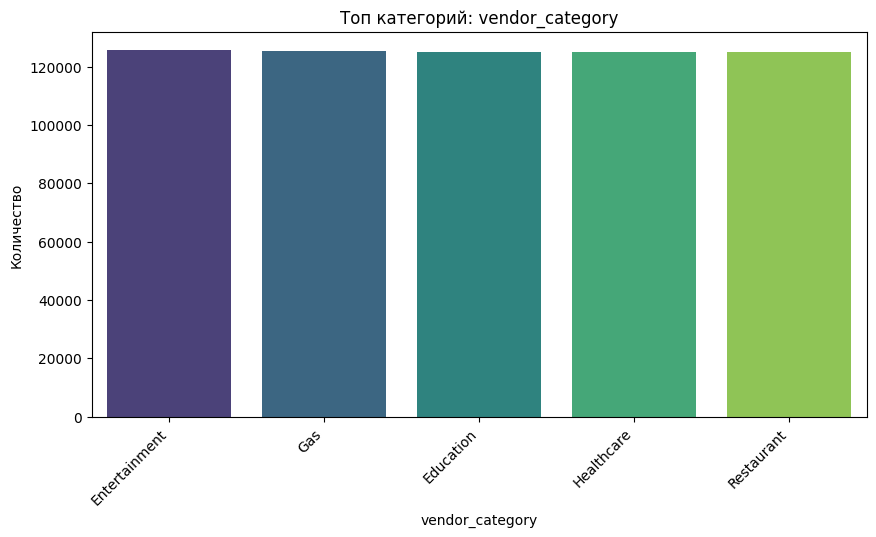


=== Top categories for country ===
country
Nigeria      113718
Brazil       107311
Russia       106544
Mexico       104908
Singapore     78281
France        72319
UK            72234
Canada        70965
Japan         70444
Germany       70102
Name: count, dtype: int64
Unique values: 12


/tmp/ipython-input-2931784778.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')


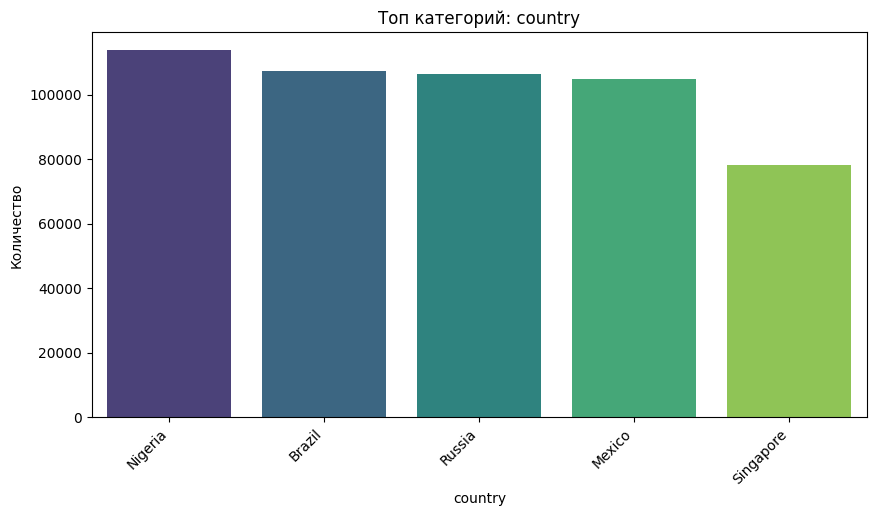


=== Top categories for card_type ===
card_type
Basic Debit        207104
Premium Debit      205720
Platinum Credit    204491
Gold Credit        193692
Basic Credit       188992
Name: count, dtype: int64
Unique values: 5


/tmp/ipython-input-2931784778.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')


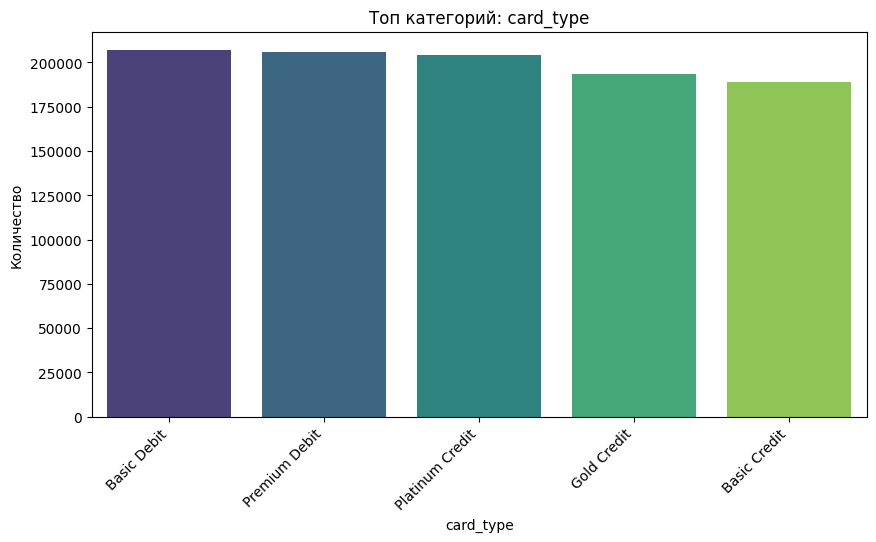


=== Top categories for channel ===
channel
web       610218
mobile    302906
pos        86875
Name: count, dtype: int64
Unique values: 3


/tmp/ipython-input-2931784778.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')


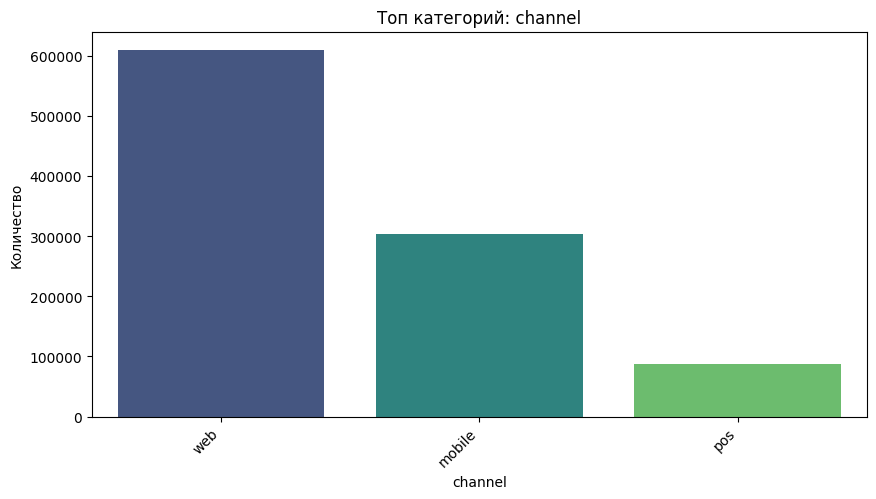

In [23]:
cat_features = ['vendor_category', 'country', 'card_type', 'channel']
for col in cat_features:
    if col in sample_trans.columns:
        print(f"\n=== Top categories for {col} ===")
        print(sample_trans[col].value_counts().head(10))
        print("Unique values:", sample_trans[col].nunique())

        plt.figure(figsize=(10,5))
        top_values = sample_trans[col].value_counts().head(5)
        sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')
        plt.xticks(rotation=45, ha='right')
        plt.title(f"Топ категорий: {col}")
        plt.ylabel("Количество")
        plt.show()

Наиболее частые vendor_category: Entertainment, Gas, Education, Healthcare, Restaurant, Retail, Grocery, Travel — примерно равномерно распределены, что говорит о сбалансированности датасета
Также можно сказать о достаточно равномерной выборке по странам, но 4 страны-лидера формируют чуть большую долю.



# Построение продуктовых гипотез

1. Определенные категории или тип вендоров is_high_risk_vendor могут быть больше подвержены мошенническим операциям и иметь более высокий риск их совершения.

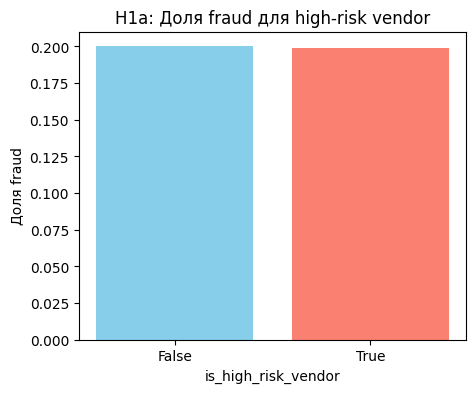

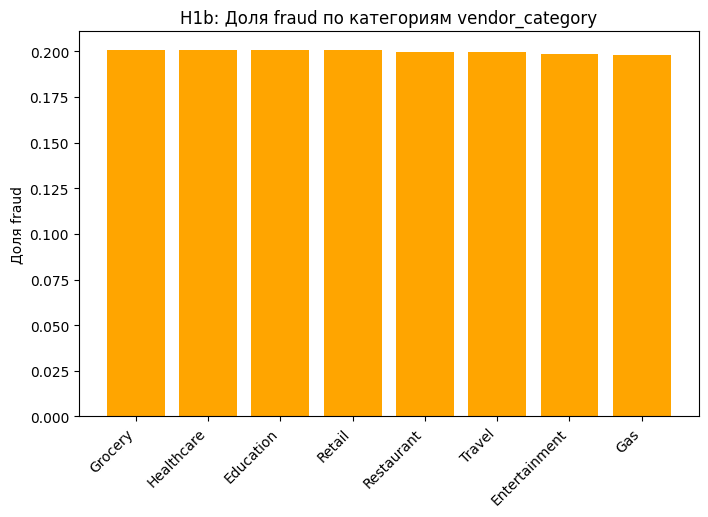

In [42]:
if 'is_high_risk_vendor' in sample_trans.columns:
    grp = sample_trans.groupby('is_high_risk_vendor')['is_fraud'].mean()
    plt.figure(figsize=(5,4))
    plt.bar(grp.index.astype(str), grp.values, color=['skyblue','salmon'])
    plt.title("H1a: Доля fraud для high-risk vendor")
    plt.ylabel("Доля fraud")
    plt.xlabel("is_high_risk_vendor")
    plt.show()

if 'vendor_category' in sample_trans.columns:
    vendor_grp = sample_trans.groupby('vendor_category')['is_fraud'].mean().sort_values(ascending=False)
    plt.figure(figsize=(8,5))
    plt.bar(vendor_grp.index, vendor_grp.values, color='orange')
    plt.xticks(rotation=45, ha='right')
    plt.title("H1b: Доля fraud по категориям vendor_category")
    plt.ylabel("Доля fraud")
    plt.show()

На графике видно, что нет определенного перекоса распределения мошеннических операций по критерию is_high_risk_vendor == True, а также по категориям вендоров

2. Наличие временных зависимостей. В выходные (is_weekend = True) и в определённое время суток уровень мошенничества выше.

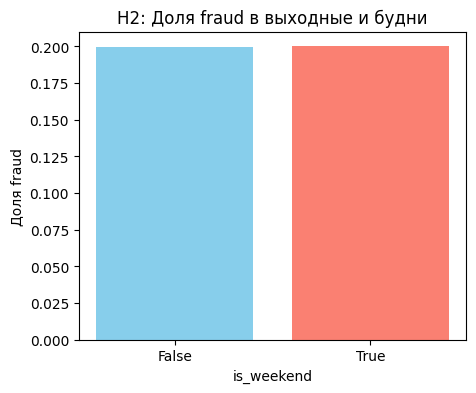

In [32]:
if 'is_weekend' in sample_trans.columns:
    grp = sample_trans.groupby('is_weekend')['is_fraud'].mean()
    plt.figure(figsize=(5,4))
    plt.bar(grp.index.astype(str), grp.values, color=['skyblue','salmon'])
    plt.title("H2: Доля fraud в выходные и будни")
    plt.ylabel("Доля fraud")
    plt.xlabel("is_weekend")
    plt.show()

3. Пользователи с аномально высокой активностью за последний час или с крупными суммами транзакций (amount) чаще совершают мошенничество.

/tmp/ipython-input-3275318195.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([legit, fraud], labels=['Legit', 'Fraud'], showfliers=False)


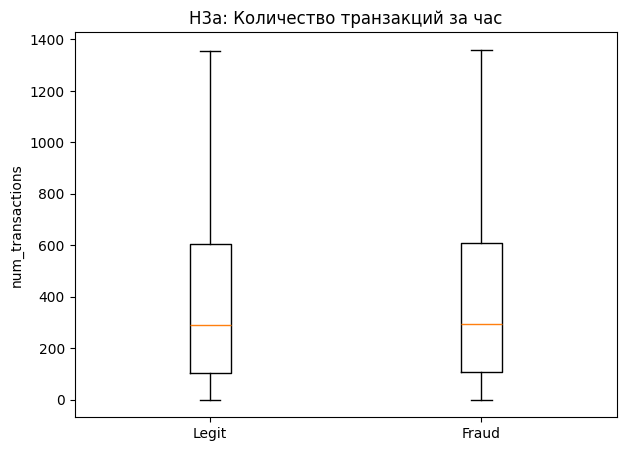

/tmp/ipython-input-3275318195.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([legit, fraud], labels=['Legit', 'Fraud'], showfliers=False)


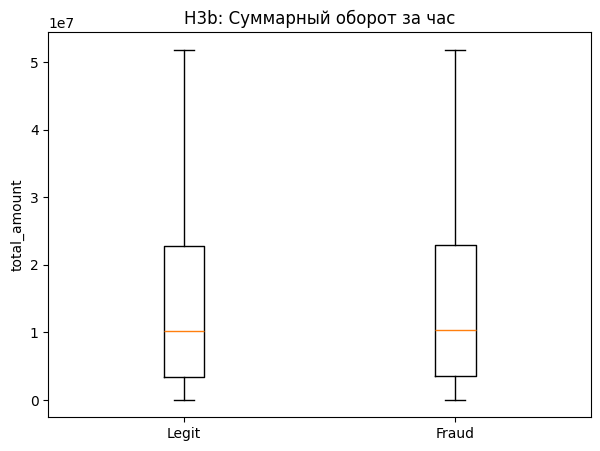

/tmp/ipython-input-3275318195.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([legit, fraud], labels=['Legit', 'Fraud'], showfliers=False)


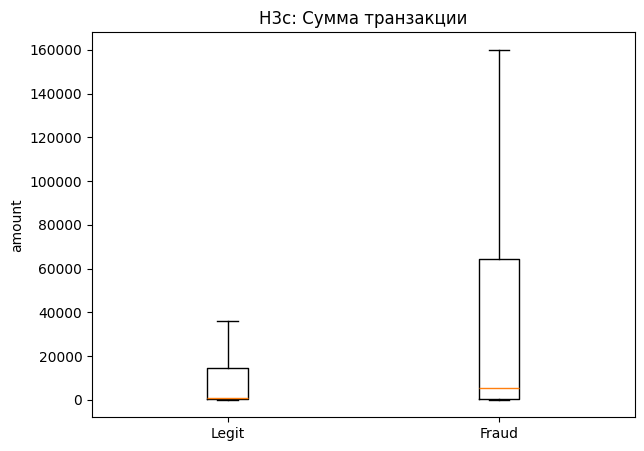

In [35]:
lha_df = pd.json_normalize(sample_trans['last_hour_activity'])
sample_trans['lha_num_transactions'] = lha_df['num_transactions']
sample_trans['lha_total_amount'] = lha_df['total_amount']

legit = sample_trans.loc[~sample_trans['is_fraud'], 'lha_num_transactions']
fraud = sample_trans.loc[sample_trans['is_fraud'], 'lha_num_transactions']
plt.figure(figsize=(7,5))
plt.boxplot([legit, fraud], labels=['Legit', 'Fraud'], showfliers=False)
plt.title("H3a: Количество транзакций за час")
plt.ylabel("num_transactions")
plt.show()

legit = sample_trans.loc[~sample_trans['is_fraud'], 'lha_total_amount']
fraud = sample_trans.loc[sample_trans['is_fraud'], 'lha_total_amount']
plt.figure(figsize=(7,5))
plt.boxplot([legit, fraud], labels=['Legit', 'Fraud'], showfliers=False)
plt.title("H3b: Суммарный оборот за час")
plt.ylabel("total_amount")
plt.show()

legit = sample_trans.loc[~sample_trans['is_fraud'], 'amount']
fraud = sample_trans.loc[sample_trans['is_fraud'], 'amount']
plt.figure(figsize=(7,5))
plt.boxplot([legit, fraud], labels=['Legit', 'Fraud'], showfliers=False)
plt.title("H3c: Сумма транзакции")
plt.ylabel("amount")
plt.show()

Медиана у Fraud выше, чем у Legit.
Разброс у Fraud намного больше (есть крайне большие суммы).

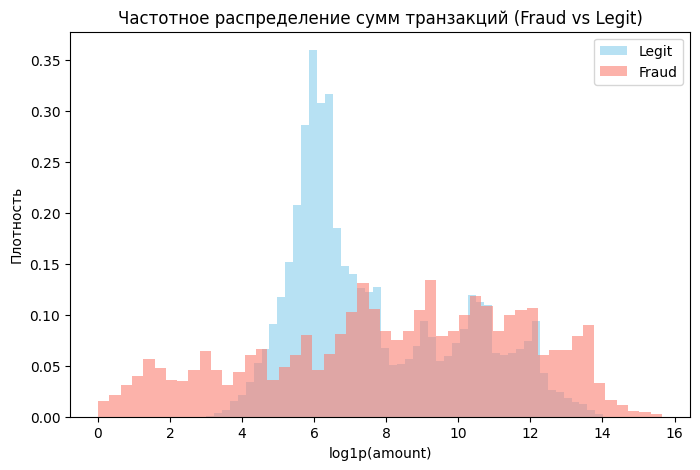

In [36]:
sample_trans['amount_log'] = np.log1p(sample_trans['amount'])

fraud_amounts = sample_trans.loc[sample_trans['is_fraud'], 'amount_log']
legit_amounts = sample_trans.loc[~sample_trans['is_fraud'], 'amount_log']

plt.figure(figsize=(8,5))
plt.hist(legit_amounts, bins=50, alpha=0.6, label='Legit', color='skyblue', density=True)
plt.hist(fraud_amounts, bins=50, alpha=0.6, label='Fraud', color='salmon', density=True)
plt.xlabel("log1p(amount)")
plt.ylabel("Плотность")
plt.title("Частотное распределение сумм транзакций (Fraud vs Legit)")
plt.legend()
plt.show()

Гистограмма по log1p(amount) подтверждает, что Fraud распределён шире и захватывает как маленькие, так и огромные суммы.

4. Определённые каналы (channel) связаны с более высоким уровнем fraud.

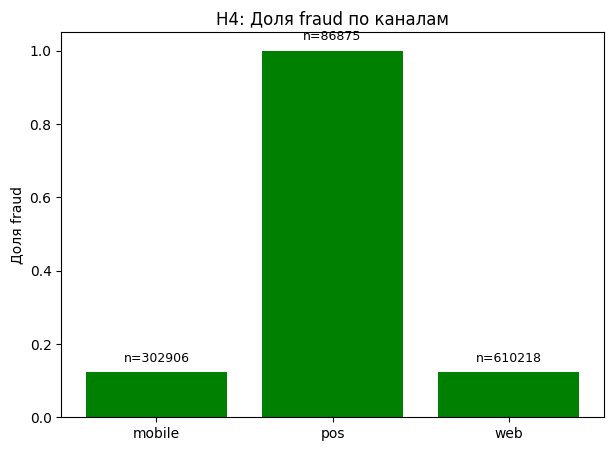

In [40]:
channel_stats = sample_trans.groupby('channel').agg(
    total=('is_fraud', 'size'),
    fraud_count=('is_fraud', 'sum')
)
channel_stats['fraud_rate'] = channel_stats['fraud_count'] / channel_stats['total']

# Построение графика
plt.figure(figsize=(7,5))
bars = plt.bar(channel_stats.index, channel_stats['fraud_rate'], color='green')

plt.title("H4: Доля fraud по каналам")
plt.ylabel("Доля fraud")
plt.ylim(0, 1.05)

for bar, total in zip(bars, channel_stats['total']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f"n={total}", ha='center', va='bottom', fontsize=9)

plt.show()


In [41]:
sample_trans['channel'].value_counts()
sample_trans.groupby('channel')['is_fraud'].value_counts()


channel  is_fraud
mobile   False       265383
         True         37523
pos      True         86875
web      False       534888
         True         75330
Name: count, dtype: int64

В данных наблюдается аномалия и все транзакции по каналу pos отмечены как мошеннические, доли по другим каналам равны